# Lab 6 - Principal Component Analysis

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction.\
You will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.


## Example Dataset
To help you understand how PCA works, you will first start with a 2D dataset which has one direction of large variation and one of smaller variation.\
The script will plot the training data. In this part of the exercise, you will visualize what happens when you use PCA to reduce the data from 2D to 1D.

In practice, you might want to reduce data from 256 to 50 dimensions, say; but using lower dimensional data in this example allows us to visualize the algorithms better.

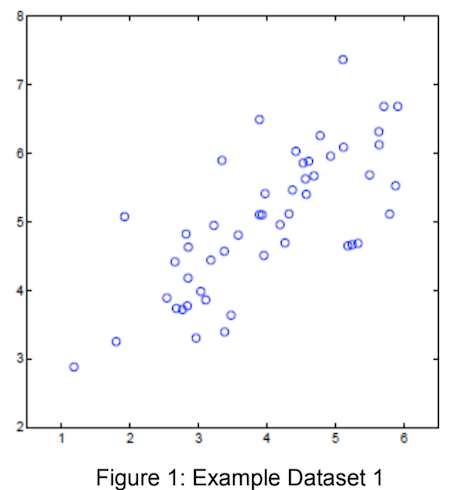

### Implementing PCA
In this part of the exercise, you will implement PCA. PCA consists of two computational steps:
1. **First:**\
You compute the covariance matrix of the data.
2. **Second:**\
You use Python's SVD function to compute the eigenvectors `U1, U2,...,Un.` These will correspond to the principal components of variation in the data.

In [2]:
## imports
import pandas as pd
import numpy as np
from numpy.linalg import eigh, norm # this is the function to use for eigenvalues and eigenvectors
from scipy.optimize import minimize ## if not installed, use conda install -c anaconda scipy
import matplotlib.pyplot as plt
import scipy.io 
import sklearn as sk

**NOTE**\
Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

**Remember:**
- Subtracting the mean from all data is equivalent to translating (moving) the data to be centered around the origin. This operation allows us to use the eigen vectors as transformation matrix to the normalized data directly without the usage of complex algebraic operations.

- Normalizing the features by their minimum-to-maximum values is to keep all features data within the same range to avoid skewed data reduction.\
 **For Example:** If building images contains two features; building area and building height (number of stories). You found out that the areas vary from 200-600 squared meters, but the height varies from 2-10 stories. the data will be very skewed (too much variations) in the area than it is in the height. we want to reduce this skew for better PCA analysis.

* moreover when we normalize the data, it falls in range 0-1, in this range, the machine learning algorithms works better or converge faster. 

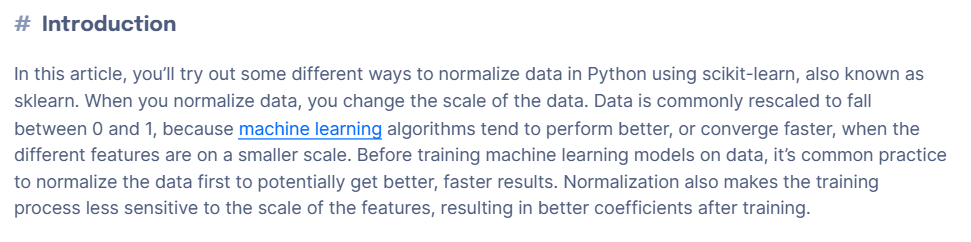



### Using Scikit-learn to normalize the data 
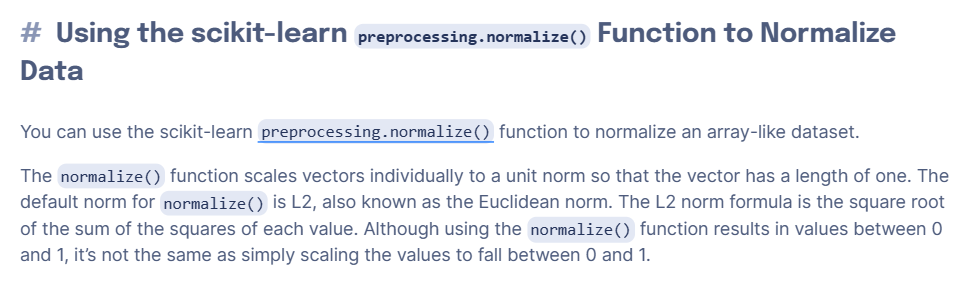

### Methods of normalization
1. Dividing by the maximum value
   -    `X_norm = X / np.max(X, axis=0)`
2. Mean Normalization
   -    `X_norm = (X - np.mean(X, axis=0)) / np.max(X, axis=0) - np.min(X, axis=0)`
3. Z score normalization <-  this is the one used here 
   -    `X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)`

In [ ]:
# TODO [1]: Fill the function featureNormalize(X) 3 lines
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0) # the standard deviation not the covariance. 
    translation = X-mu
    normalized_X = translation/sigma # to normalize the data, we can divide it on its standard deviation
    # normalized_X = translation/sk.preprocessing.normalize(translation) # this cause an error in assertion, but I don't understand why it is not correct, ahh because this is not the required technique here, we want to use the Z normalization :).
    return (normalized_X, mu, sigma)


In [4]:
### Test Your Implementation ###
np.random.seed(3)
test_features = np.random.random((10,2))
actual_features_mean = np.array([0.35502116, 0.50634598])
actual_features_sigma = np.array([0.29845715, 0.18951448])
actual_features_normalized = np.array([[ 0.65596265,  1.064836  ], [-0.21482622,  0.02364791], [ 1.8023552 ,  2.05761116],
                                  [-0.76873967, -1.57825993], [-1.01707718, -0.34581074], [-1.0894192 , -0.2612611 ], 
                                  [ 0.98547778, -1.20232873], [ 1.07631445,  0.44596504], [-1.10916853,  0.27706645], 
                                  [-0.32087927, -0.48146605]])

(test_features_normalized, test_features_mean, test_features_sigma) = featureNormalize(test_features)
## Assertions
normalization_truth = np.round(actual_features_normalized,2) == np.round(test_features_normalized,2)
assert normalization_truth.all() , "Incorrect feature normalization calculated"
mean_truth = np.round(test_features_mean, 2) == np.round(actual_features_mean,2)
assert mean_truth.all(), "Incorrect feature mean calculated"
sigma_truth =  np.round(test_features_sigma,2) == np.round(actual_features_sigma,2)
assert sigma_truth.all(), "Incorrect feature sigma calculated" 

After normalizing the data, you can run PCA to compute the principal components. You
task is to complete the code to compute the principal components of the dataset and
print these principal components.

### Description of svd 
* svd is an acronym for Singular Value Decomposition.
* before digging deeper into how to use the svd function, we need to understand what is the singular value decomposition (SVD) and why we need it.
* so lets define the main points of svd 
    1. svd is a method used for data reduction & diminsionality reduction.
    2. it is a foundation for many machine learning algorithm
    3. it is a general purpose tool used for numerical linear algebra
    4. it helps in reducing the data into the key features used for describing & analyzing the data
    5. usually it is the first step in many diminsionality reduction machine learning algorithms
    6. it is a data driven generalization of fourier transform (fft)
    7. the goal of the svd is to tailor a new coordinates based on the data we have
    8. so it tailors things according to a specific problem
    9. it is also used to solve linear system of matrix equations (Ax = b)
    10. it is a basis for PCA (Principal Component Analysis)
    11. and it heavily depends on the correlation between the features
    12. it used simple nad interpretable linear algebra.    

### how to use svd
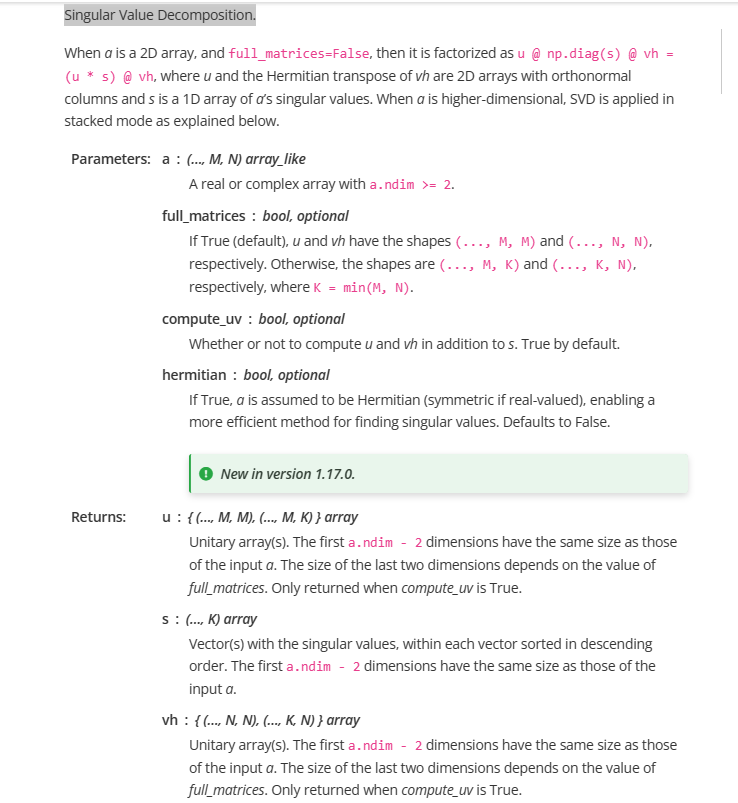

In [5]:
''' 
Before evaluating the eigen vectors using the svd, lets do it manually here.
'''
# 1. lets define a random matrix 
A = np.array([[-5,2,3],[2,5,1],[-3,1,-5]])
# 2. lets compute its dot product with its transpose
# print (A.T @ A)
# 3. lets evaluate the eigen vectors and eigen values of the above matrix using eigh function
eigenVals, eigenVectors =  eigh(A.T @ A)
eigenVectors # each column is an eigen vector (0.408, -0.816, 0.408) is an eigen vector and so on. 
# to get the first eigen vector
first_eigen = eigenVectors[:,0]
second_eigen = eigenVectors[:,1]
third_eigen = eigenVectors[:,2]
# 4. now we lets define the matrix U
'''
U is an orthonormal matrix, so U^-1 = U.T
the columns of the matrix U is called left singular vectors,
which represents the normalized values resulted by multiplying the matrix A with the eigen vectors.
'''
u0 = A@first_eigen / norm(A@first_eigen)
u1 = A@second_eigen / norm(A@second_eigen)
u2 = A@third_eigen / norm(A@third_eigen)
U = np.array([u0, u1, u2]).T
# 5. if we multiplied this U by our A matrix, then multiply them by eigen vectors, we should get a diagonal matrix
S = np.round(U.T @ A @ eigenVectors, decimals=4)

# so now if we want to get A, with knowing U, we can do the following
M = np.round(U@S@eigenVectors.T, decimals = 2) # this is exactly what SVD is. :) 
# print (M)
# print(A)

u,s,vh = np.linalg.svd(A)
'''
u -> is the left singular vectors
s -> is the singular values
vh -> is the right singular vectors
A = u @ np.diag(s) @ vh
'''

'\nu -> is the left singular vectors\ns -> is the singular values\nvh -> is the right singular vectors\nA = u @ np.diag(s) @ vh\n'

In [6]:
# TODO [2]: Fill the function PCA(X) where X represents a given dataset. Each row in X represents a data point.
def pca(X):
    # First, we need to compute the covariance matrix of X. (Check np.cov)
    cov = np.cov(X, rowvar=False)
    # Second, we need to find the eigenvectors of this covariance matrix.
    eigenVectors, eigenVals = eigh(cov)
    # Why do we want to calculate the eigenvectors for?
    '''
    we need to find the eigenvectors and eigenvalues to be able to evaluate the diminsionality of the data which has the greatest variance. 
    '''
    ## Hint: Check for the function np.linalg.svd. What does this function do? What does it return?
    
    #Replace None with the needed values returned from np.linalg.svd.
    #If you do not know which returned values are needed from this function, you can check where this function is called in this file. 
    # u,s,vh = np.linalg.svd(cov) -> why this is not correct, we should get the eigens for the cov not the matrix itself. 
    u,s,vh = np.linalg.svd(X) 
    # now we returns the u and s
    return vh.T,s

## Dimensionality Reduction with PCA
After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space (e.g., projecting the data from 2D to 1D).\
In this part of the exercise, you will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional
space.

In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data. By using the projected data, you can train your model faster as there are less dimensions in the input, thus avoiding the curse of dimensionality.

### Projecting the data onto the principal components
You should now complete the code in `projectData().`\
Specifically, you are given a dataset X, the principal components U, and the desired number of dimensions to reduce to K.\
You should project each example in X onto the top K components in U.

In [7]:
### NOTE: we assume that the previous steps were correct so that the assertion works

# TODO [3]: Fill the function projectData (X,U,K) (~1 line). Your code should be vectorized
def projectData(X, U, K):
    # in U, I want to get all rows, and from the first column to the Kth column.,
    # Z = U[:,K].T @ X # why this is not correct? isnt it UT * Y = Z ?  
    Z = X @ U[:,:K]
    return Z

In [8]:
### Test Your Implementation ###
np.random.seed(3)
test_features = np.random.random((10,2))
test_u, test_s = pca(test_features)
z_test = projectData(test_features, test_u, 1)
z_actual = np.array([[-0.89662942], [-0.57867148], [-1.2601911 ], [-0.2396097 ], [-0.37161185],
                     [-0.37010177], [-0.62948026], [-0.88682734], [-0.44470977], [-0.48486548]])

z_truth = np.round(z_actual, 2) == np.round(z_test, 2)
assert z_truth.all(), "Incorrect projection"

## Reconstructing an approximation of the data
One of the cool things about PCA is that after projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space. Think of it as data compression technique without losing the important info. We want you to test it and validate that by yourselves!

Your task is to complete `recoverData()` to project each example in Z back onto the original space and return the recovered approximation in X.

In [9]:
# TODO [4]: Fill the function recoverData (Z, U, K) (~1 line). Check the dimensions.
def recoverData(Z, U, K):
    # this is logically correct, that is because U(-1) = U.T
    # so if we have Z = X.U then multiplying both from right by U.T will get Z @ U.T = X <= which is the original matrix
    X_rec = Z @ U[:,:K].T
    return X_rec

In [10]:
### Test Your Implementation ###
np.random.seed(3)
test_features = np.random.random((10,2))
test_u, test_s = pca(test_features)
z_test = projectData(test_features, test_u, 1)

recovered_test = recoverData(z_test, test_u, 1)
recovered_actual = np.array([[0.57394047, 0.6888662 ], [0.37041277, 0.44458415], [0.80665955, 0.96818489], [0.1533763, 0.18408834], [0.23787205, 0.2855035 ],
                             [0.23690544, 0.28434334], [0.40293592, 0.48361973], [0.56766608, 0.68133542], [0.28466269, 0.34166349], [0.31036672, 0.37251448]])

recovery_truth = np.round(recovered_test, 2) == np.round(recovered_actual, 2)
assert recovery_truth.all(), "Incorrect recovering"


## Visualizing the projections
After completing both `projectData()` and `recoverData()`, the script will now perform both the projection and approximate reconstruction to show how the projection affects the data. The projection effectively only retains the information in the direction given by U1.


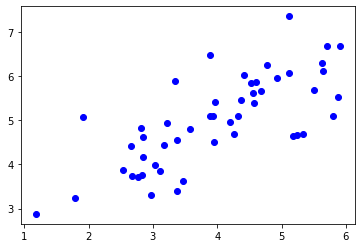

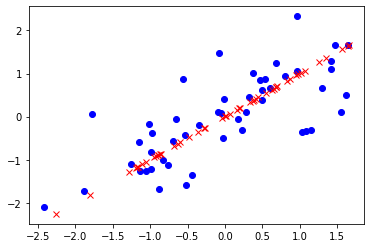

In [17]:
############ DONOT CHANGE CODE ############

def displayData(X):
    num_images = len(X)
    rows = int(num_images ** .5)
    cols = int(num_images ** .5)
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True)
    img_num = 0

    for i in range(rows):
        for j in range(cols):
            # Convert column vector into 32x232 pixel matrix
            #  transpose
            img = X[img_num, :].reshape(32, 32).T
            ax[i][j].imshow(img, cmap='gray')
            img_num += 1
    return (fig, ax)


raw_mat = scipy.io.loadmat("ex7data1.mat")
X = raw_mat.get("X")
plt.cla()
plt.plot(X[:, 0], X[:, 1], 'bo')
plt.show()

X_norm, mu, sigma = featureNormalize(X)
U, S = pca(X_norm)

K = 1
Z = projectData(X_norm, U, K)
X_rec = recoverData(Z, U, K)

plt.cla()
plt.plot(X_norm[:, 0], X_norm[:, 1], 'bo')
plt.plot(X_rec[:, 0], X_rec[:, 1], 'rx')
plt.show()

## Face Image Dataset
In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction. The dataset ex7faces.mat contains a dataset X of face images, each `32x32` in grayscale. Each row of X corresponds to one face image (a row vector of length 1024). The next step in the script will load and visualize the first 100 of these face images.

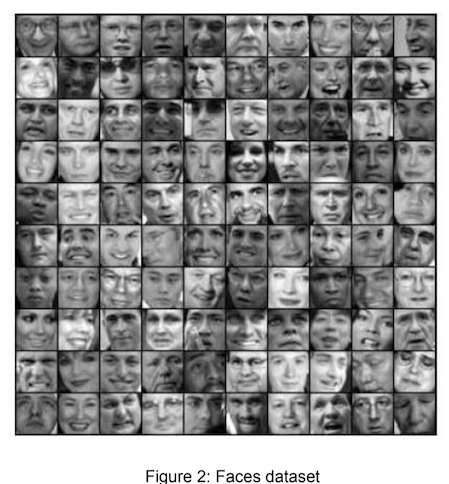

## PCA on Faces
To run PCA on the face dataset, we first normalize the dataset by subtracting the mean of each feature from the data matrix X. The script will do this for you and then run your PCA code. After running PCA, you will obtain the principal components of the dataset.

Notice that each principal component in U (each row) is a vector of length n (where for the face dataset, `n = 1024`). It turns out that we can visualize these principal components by reshaping each of them into a `32x32` matrix that corresponds to the pixels in the original dataset.\
The script displays the first 36 principal components that describe the largest variations. If you want, you can also change the code to display more principal components to see how they capture more and more details.




## Dimensionality Reduction
Now that you have computed the principal components for the face dataset, you can use it to reduce the dimension of the face dataset. This allows you to use your learning algorithm with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions. This can help speed up your learning algorithm.

The next part in the script will project the face dataset onto only the first 100 principal components. Concretely, each face image is now described by a vector of 100 dimensions.
To understand what is lost in the dimension reduction, you can recover the data using only the projected dataset. In the script, an approximate recovery of the data is performed and the original and projected face images are displayed side by side.


#### disclaimer 
*This lab is adopted from Stanford’s CS229 Andrew NG lecture notes.*

C:\Users\20115\AppData\Local\Temp\ipykernel_9732\2470043163.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  face_grid.show()
C:\Users\20115\AppData\Local\Temp\ipykernel_9732\2470043163.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  face_grid.show()
C:\Users\20115\AppData\Local\Temp\ipykernel_9732\2470043163.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


Done!


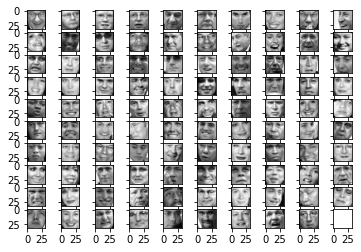

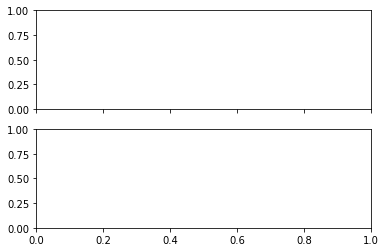

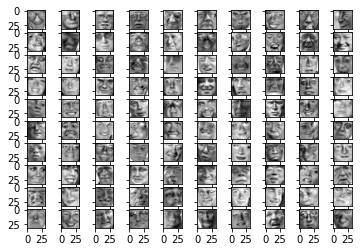

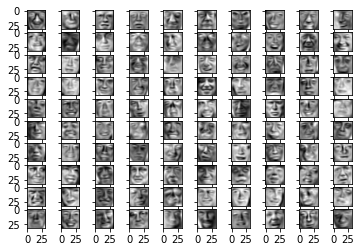

In [19]:
############ DONOT CHANGE CODE ############
############ IGNORE ANY WARNING ############

# Loading and Visualizing Face Data
raw_mat = scipy.io.loadmat("ex7faces.mat")
X = raw_mat.get("X")
face_grid, ax = displayData(X[:100, :])
face_grid.show()

X_norm, mu, sigma = featureNormalize(X)
U, S = pca(X_norm)

face_grid, ax = displayData(U[:, :50].T)
face_grid.show()

# Dimension Reduction on Faces
K = 100
Z = projectData(X_norm, U, K)

# Visualization of Faces after PCA
K = 100
X_rec = recoverData(Z, U, K)

plt.close()
plt.cla()
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
f, ax1 = displayData(X_norm[:100, :])
f, ax2 = displayData(X_rec[:100, :])
f.show()
print("Done!")